# data loading

In [1]:
from data_loader import Data_loader

# 用前2/3的数据用于训练,后1/3数据用于测试
# window_length = 1.5 years

dl = Data_loader()
start_idx = 0
window_train, window_test = dl.get_window(start_idx=start_idx)

FileNotFoundError: [Errno 2] No such file or directory: 'data/nasdaq_19900101_20031231.csv'

# 在每个window内筛选paris



## 1.normalized price distance初筛

Basic Statistics for distances:
Mean: 5286219.084745647
Median: 16.611412381093956
Standard Deviation: 114968276.66669613

Percentiles:
0th percentile: 0.06935615485767097
25th percentile: 6.543446734558261
50th percentile: 16.611412381093956
75th percentile: 41.862403733135274
100th percentile: 2763430370.728946

Minimum: 0.06935615485767097
Maximum: 2763430370.728946


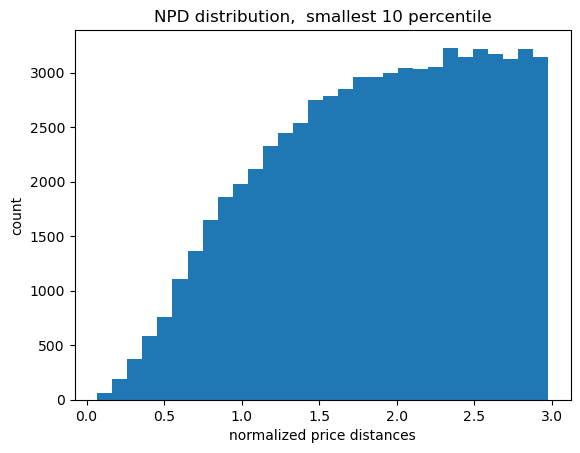

In [2]:
from pair_filter import NPD_filter

NPD = NPD_filter(window_train)

NPD.visualize_price_distance()


In [7]:
pairs, distance = NPD.select_pairs(percentile=5, verbose=True)

34018 pairs selected
min distance 0.06935615485767097
max distance 1.921438805060201


## 2.OLS regressin进一步筛选

$y_{1, t} = \gamma * y_{2, t} + \mu + \epsilon_{t}$

测试epsilon是否staionary

In [17]:
from pair_filter import OLS_filter

OLS = OLS_filter(window_train)

pairs, params = OLS.select_pairs(pairs, verbose=True)

11323 out of 11323 pairs passed the test
pass rate: 1.00


# 设计回测

In [19]:
# backtest有待模块化
# 先试用一组pair和param做实验
import numpy as np
import pandas as pd

pairs_bt = np.array(pairs)
params_bt = np.array(params)


idx = 10
stock1 = pairs_bt[idx][0]
stock2 = pairs_bt[idx][1]
params_bt = params_bt[idx] # (beta, mu, sigma^2)

beta = params_bt[0]
mu = params_bt[1]
sigma_2 = params_bt[2]

data_test = window_test


residuals = data_test[stock1] - beta * data_test[stock2] - mu

display(residuals)

date
1990-12-31    0.066108
1991-01-02    0.106076
1991-01-03   -0.103955
1991-01-04    0.021045
1991-01-07    0.061013
                ...   
1991-06-25    0.311013
1991-06-26    0.390950
1991-06-27    0.475981
1991-06-28    0.305918
1991-07-01    0.350981
Length: 127, dtype: float64

In [20]:
# choosing threshold for executing
# simple version: assume residuals are gaussian (0, sigma^2)

from scipy import stats
from scipy.optimize import minimize_scalar

def threshold_gaussian(sigma):
    # Find the maximum profit (by minimizing the negative)

    def neg_profit(x):
        return -1 * (1 - stats.norm.cdf(x/sigma)) * x
    

    result = minimize_scalar(
        neg_profit,
        args=(),
        bounds=(0, 3*sigma),  # Reasonable bounds for search
        method='bounded'
    )
    
    # return the threshold
    return result.x

execution_thre = threshold_gaussian(np.sqrt(sigma_2))

In [21]:
trade_table = pd.DataFrame({'residuals': residuals,
                            'stock1_price': data_test[stock1],
                            'stock2_price': data_test[stock2],
                            'beta': beta,
                            'mu': mu
                            },
              index = residuals.index)

# 计算price1 - beta*price2
trade_table['pr1-beta*pr2'] = trade_table["stock1_price"] - trade_table['beta'] * trade_table['stock2_price']

tra_signals = np.where(residuals >= execution_thre, -1, np.where(residuals <= -execution_thre, 1, 0))
trade_table["trade_signal"] = tra_signals

# 当residual符号出现反转时,生成unwind signal
prev_sign = np.sign(trade_table['residuals']).shift(1)
curr_sign = np.sign(trade_table['residuals'])
trade_table['unwind_signal'] = (curr_sign != prev_sign).astype(int)
trade_table.loc[trade_table.index[0], 'unwind_signal'] = 0


trade_table

,residuals,stock1_price,stock2_price,beta,mu,pr1-beta*pr2,trade_signal,unwind_signal
date,,,,,,,,
1990-12-31,0.066108,11.250,11.250,0.680253,3.531048,3.597156,0,0
1991-01-02,0.106076,11.375,11.375,0.680253,3.531048,3.637124,0,0
1991-01-03,-0.103955,11.250,11.500,0.680253,3.531048,3.427092,0,1
1991-01-04,0.021045,11.375,11.500,0.680253,3.531048,3.552092,0,1
1991-01-07,0.061013,11.500,11.625,0.680253,3.531048,3.592061,0,0
...,...,...,...,...,...,...,...,...
1991-06-25,0.311013,11.750,11.625,0.680253,3.531048,3.842061,-1,0
1991-06-26,0.390950,12.000,11.875,0.680253,3.531048,3.921998,-1,0
1991-06-27,0.475981,12.000,11.750,0.680253,3.531048,4.007029,-1,0


In [22]:
portfolio_value = 1 # initial value to be 1
portfolio_value_list = []
position_list = []
prev_price = None
position = 0 # 0:position close; 1:long spread; 2: short spread

for idx, row in trade_table.iterrows():

    # current position is closed
    if position == 0:
        if row['trade_signal'] != 0: # open a position if receive the trade signal
            position = row["trade_signal"]
    
    # current position is long
    elif position == 1:
        curr_price = row['pr1-beta*pr2']
        ret = curr_price / prev_price
        portfolio_value = portfolio_value * ret

        if row["unwind_signal"] == 1:
            position = 0
    
    # current position is short
    elif position == -1:
        curr_price = row['pr1-beta*pr2']
        ret = 2 - curr_price/prev_price
        portfolio_value = portfolio_value * ret

        if row["unwind_signal"] == 1:
            position = 0
    
    else:
        raise "Position invalid"

    
    prev_price = row['pr1-beta*pr2']
    position_list.append(position)
    portfolio_value_list.append(portfolio_value)

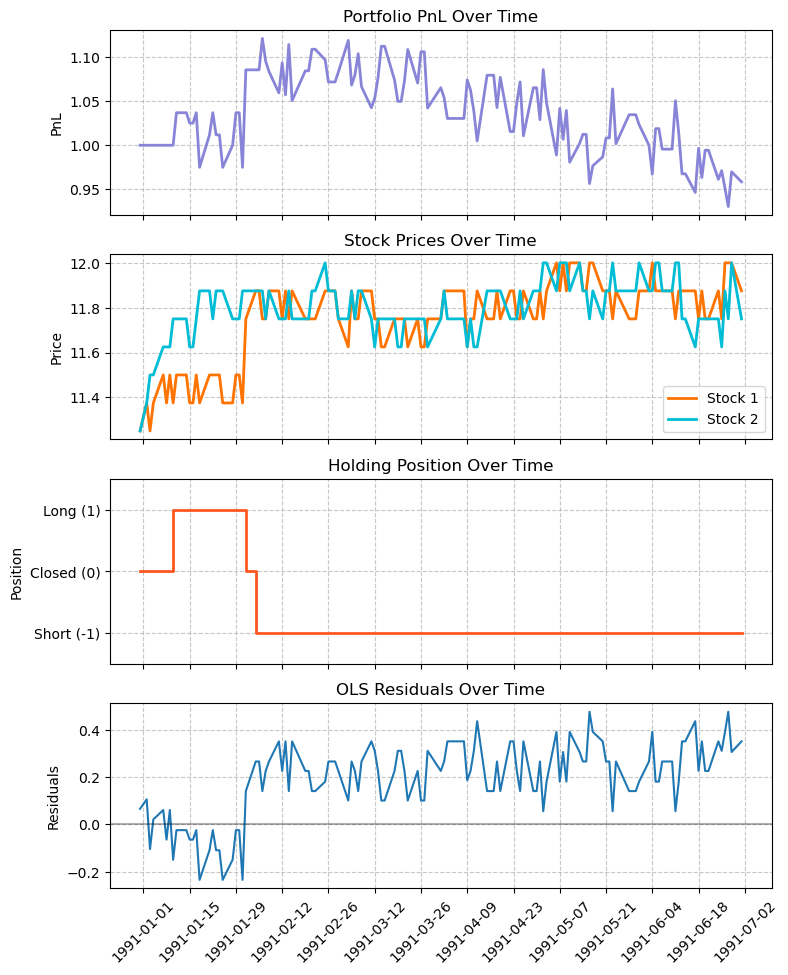

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = trade_table.index

# Create figure with subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
# fig.suptitle('Portfolio Performance Dashboard', fontsize=16)

# Format x-axis dates
date_format = mdates.DateFormatter('%Y-%m-%d')
for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)

# 1. Portfolio PnL over time
ax1.plot(dates, portfolio_value_list, color='#8884d8', linewidth=2)
# ax1.axhline(y=1, color='black', linestyle='-', alpha=0.3)
ax1.set_title('Portfolio PnL Over Time')
ax1.set_ylabel('PnL')
# ax1.fill_between(df['date'], df['portfolio_pnl'], 0, 
#                 where=(df['portfolio_pnl'] >= 0), color='#8884d8', alpha=0.3)
# ax1.fill_between(df['date'], df['portfolio_pnl'], 0, 
#                 where=(df['portfolio_pnl'] < 0), color='#d88884', alpha=0.3)

# 2. Stock prices over time
ax2.plot(dates, trade_table['stock1_price'], color='#ff7300', linewidth=2, label='Stock 1')
ax2.plot(dates, trade_table['stock2_price'], color='#00bcd4', linewidth=2, label='Stock 2')
ax2.set_title('Stock Prices Over Time')
ax2.set_ylabel('Price')
ax2.legend()

# 3. Holding position over time
ax3.step(dates, position_list, color='#ff5722', linewidth=2, where='post')
# ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_title('Holding Position Over Time')
ax3.set_ylabel('Position')
ax3.set_yticks([-1, 0, 1])
ax3.set_yticklabels(['Short (-1)', 'Closed (0)', 'Long (1)'])
ax3.set_ylim(-1.5, 1.5)

# 4. residuals plot
ax4.plot(dates, trade_table['residuals'])
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.set_title('OLS Residuals Over Time')
ax4.set_ylabel('Residuals')



# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Save or display the figure
# plt.savefig('portfolio_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
